# CSW tensor-product or generalized representation?

- does dropout encourage generalized?

In [1]:
import numpy as np
import itertools
from glob import glob as glob

from cswsims import *
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

/Users/abeukers/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


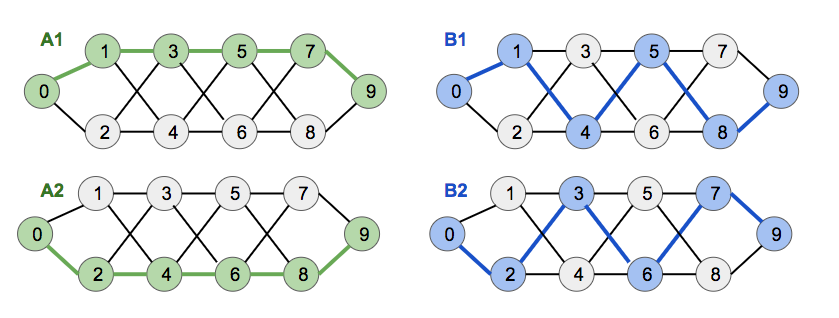

In [2]:
def load_data_arr(stsize,csw,shiftpr,train_or_eval,maxN=None):
  fpathL = glob('models/csw_tpgen/state_%i-csw_%i-shiftpr_%i*fp6bp3/*/%s_data.npy'%(stsize,csw,shiftpr,train_or_eval))
  print('found N =',len(fpathL))
  if maxN: fpathL = fpathL[:maxN]
  sub_arr0 = np.load(fpathL[0])
  data_arr = np.empty([len(fpathL),*sub_arr0.shape],dtype=sub_arr0.dtype)
  for idx,fpath in enumerate(fpathL):
#     print(fpath)
    sub_data_arr = np.load(fpath)
    data_arr[idx] = sub_data_arr
  return data_arr


## eval measure
- take into account csw probability
- focus on depth 2,3,4
- two versions: prmatching,correct response
    - prmatching: difference between sm and true pr
    - correctresp: argmax corresponds to transition?

In [86]:
def compute_scores_on_seq(eval_data,cswpr,seq):
  """
  evaluates a group of networks on a given sequence
  returns a performance score for each network
  performance score measures how much the networks 
    softmax activations on depth 2,3,4 transitions
    deviate (in abs) from the probability matching beahvior
  """
  yhat = eval_data[seq]['yhat']
  xbatch = eval_data[seq]['xbatch']
  ## indexes
  # only look at depth 2,3,4 tsteps
  edge_idx = np.vstack([np.arange(d,42,7) for d in [2,3,4]]).reshape(-1,order='F') 
  # get softmax activation of tonodes
  true_tonode = xbatch[0][1+edge_idx]
  # activation for relevant transitions
  yhat_tonode = yhat[:,edge_idx,true_tonode]
  # average over transitions 
  net_scores = np.mean(np.abs(yhat_tonode-(cswpr/100)),1)
  return net_scores

def compute_aggregate_score(eval_data,cswpr):
  """
  computes score that takes into account nets behavior
    in every sequence in eval_data
  """
  seqL = eval_data.dtype.names
  score_on_seq = np.ones([len(seqL),len(eval_data)])*898
  for idx,seq in enumerate(seqL):
    score_on_seq[idx] = compute_scores_on_seq(eval_data,cswpr,seq)
  return score_on_seq.mean(0)
  

found N = 22
found N = 22
found N = 22
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23


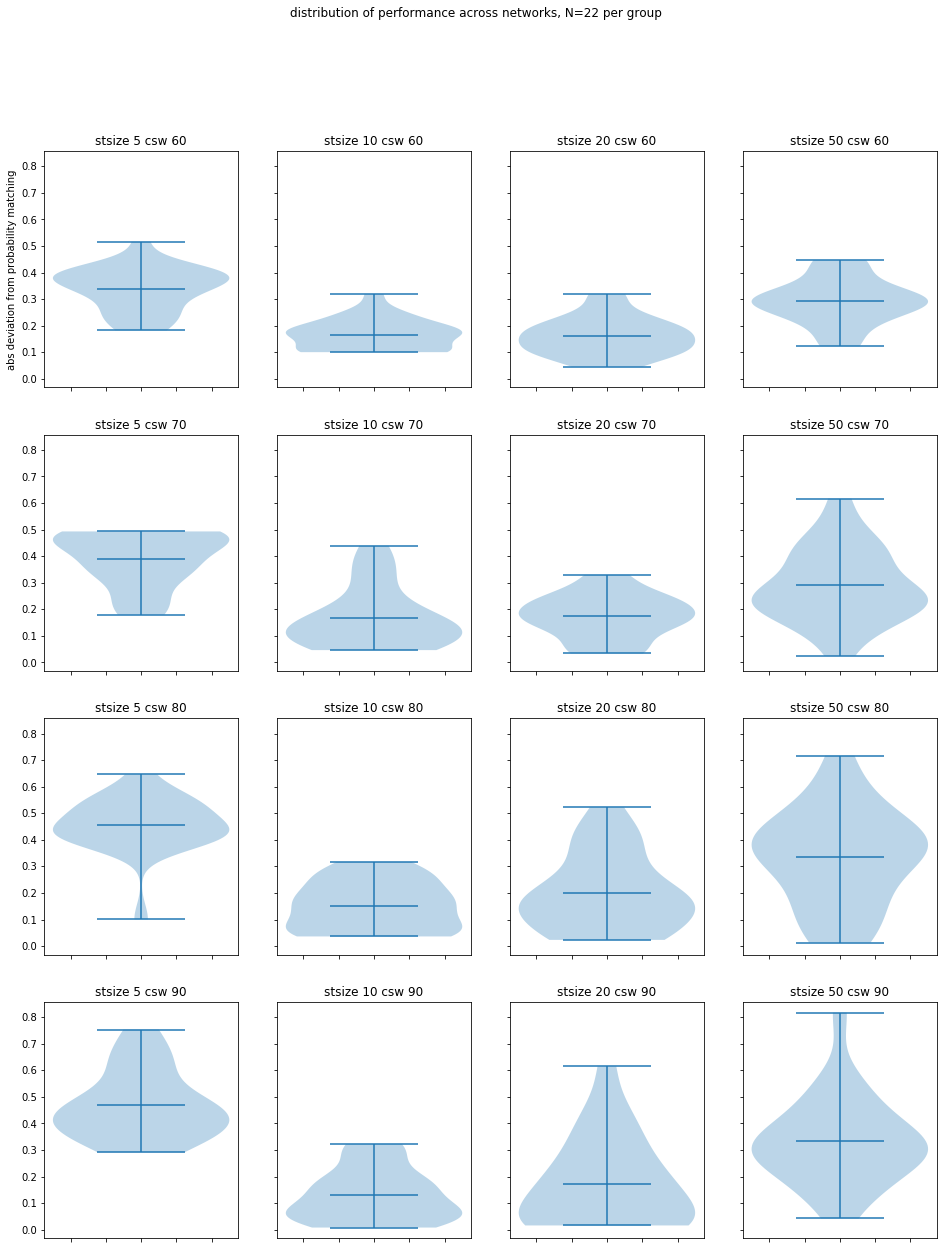

In [116]:
shiftpr = 10
cswL = [60,70,80,90]
stsizeL = [5,10,20,50]
# cswL = [60,70]
# stsizeL = [5,10]
N = 25
fig,axarr = plt.subplots(len(cswL),len(stsizeL),figsize=(4*len(cswL),5*len(stsizeL)),sharey=True)
for (st_idx,stsize),(csw_idx,cswpr) in itertools.product(enumerate(stsizeL),enumerate(cswL)):
  ax = axarr[csw_idx,st_idx]
  # load data compute score
  eval_data = load_data_arr(stsize,cswpr,shiftpr,'eval',maxN=N)
  net_agg_score = compute_aggregate_score(eval_data,cswpr)
  # plot
  ax.violinplot(net_agg_score,showmeans=True)
  ax.set_title('stsize %i csw %i'%(stsize,cswpr))
  ax.set_xticklabels([])
axarr[0,0].set_ylabel('abs deviation from probability matching')
plt.suptitle('distribution of performance across networks, N=22 per group')
plt.savefig('figures/csw_tpgen/agg_performance_score_violin-shiftpr%i'%(shiftpr))

## plot train softmax

In [3]:
import itertools

# stsizeL = [5, 10, 20, 50]
stsizeL = [50]
cswL = [60, 70, 80, 90]

cswL = [90]
shiftprL = [10, 50, 90]
shiftprL = [90]

train_or_eval = 'train'

for stsize,csw,shiftpr in itertools.product(stsizeL,cswL,shiftprL):
  print(stsize,csw,shiftpr)
  ## load data
  tr_data = load_data_arr(stsize,csw,shiftpr,train_or_eval)
  tr_yhat = tr_data['yhat'].squeeze()
  ## plot
  fig,axarr = plt.subplots(7,6,figsize=(20,3*7),sharex=True,sharey=True); axarr = axarr.T.reshape(-1)
  for depth in range(42):
    ax = axarr[depth]
    M = tr_yhat.mean(0)[:,depth,:]
    S = tr_yhat.std(0)[:,depth,:]/np.sqrt(len(tr_yhat))
    ax.plot(M)
    for m,s in zip(M.T,S.T):
      ax.fill_between(range(len(m)),m-s,m+s,alpha=.3)
    ax.set_ylim(-0.05,1.05)
    ax.set_title(depth)
  plt.suptitle('stsize=%i csw=%i shift=%i, N=%i'%(stsize,csw,shiftpr,len(tr_yhat)),fontsize=20)
  plt.savefig('figures/csw_tpgen/train_yhat/trainact-stsize%i-csw%i-shift%i-fp6bp3'%(stsize,csw,shiftpr))
  plt.close(fig)

50 90 90
found N = 23


# eval data

### svm analysis
- train on pomdp marker, test on sequence
- once all data is loaded, make lots of plots

In [4]:
from sklearn.svm import LinearSVC
def fiteval_svm(trA,trB,evalseq):
  """ 
  inputs are (net,time,stdim)
  returns (net,evaltime)
  """
  X = np.concatenate([trA,trB],1)
  Y = np.concatenate([np.ones([len(X),trA.shape[1]]),
                      np.zeros([len(X),trB.shape[1]])],1)
  svmeval_arr = np.zeros(evalseq.shape[:2])
  for net in range(len(X)):  
    svm = LinearSVC()
    svm.fit(X[net],Y[net])
    svm_eval = svm.decision_function(evalseq[net])
    svmeval_arr[net] = svm_eval
  return svmeval_arr

### svm fit to each time step separately

In [7]:
# svm train and eval seq
tr_seq1,tr_seq2 = 'A1A1A1A1A1A1','B1B1B1B1B1B1'
te_seq1,te_seq2 = tr_seq1,tr_seq2

maxN = 25

sweeping = 'stsize' #-#
stsizeL = [10,20,50]
cswL = [60,70,80,90]
shiftprL = [10,50,90]

# sweeping = 'csw' #-#
# stsizeL = [5,10,20,50]
# cswL = [70,80,90]
# shiftprL = [10,50,90]


for shiftpr,csw in itertools.product(shiftprL,cswL): #-# sweep stsize 
# for shiftpr,stsize in itertools.product(shiftprL,stsizeL): #-# sweep csw
  fig,axarr = plt.subplots(7,1,figsize=(20,7*4));axarr=axarr.reshape(-1)
  for idx,stsize in enumerate(stsizeL): #-# sweep stsize
#   for idx,csw in enumerate(cswL): #-# sweep csw
    # load data
    try: 
      eval_data = load_data_arr(stsize,csw,shiftpr,'eval',maxN=maxN)
      Nnets,tsteps,dim = eval_data[tr_seq1]['states'].shape
    except: print('unable to load',stsize,csw,shiftpr);continue

    color = ['green','red','blue'][idx]
    # svm eval seq
    evalseqA = eval_data[te_seq1]['states'][:,-7:,:]
    evalseqB = eval_data[te_seq2]['states'][:,-7:,:]
    for tr_idx in range(7):
      ax = axarr[tr_idx]
      ax.set_title('train index = %i'%(tr_idx))
      ax.axvline(tr_idx)
      # svm train seq
      tr_idx_ = tsteps-7+tr_idx
      trA = np.expand_dims(eval_data[tr_seq1]['states'][:,tr_idx_,:],1)
      trB = np.expand_dims(eval_data[tr_seq2]['states'][:,tr_idx_,:],1)
      # plot
      for seq_idx,evalseq in enumerate([evalseqA,evalseqB]):
        # mean and err svmtraj over subjects
        svm_traj = fiteval_svm(trA,trB,evalseq)
        ### wrap this in a plotting function which takes svm_traj ?
        Mtraj = svm_traj.mean(0)
        Straj = svm_traj.std(0)/np.sqrt(len(svm_traj))
        ## plot
        if sweeping=='stsize':
          lab = "stsize%i, n=%i"%(stsize,len(svm_traj))
        elif sweeping=='csw':
          lab = "csw%i, n=%i"%(csw,len(svm_traj))
        ax.plot(Mtraj,lw=2,color=color,label=['A ','B '][seq_idx]+lab,ls=['-','--'][seq_idx])
        ax.fill_between(range(len(Mtraj)),Mtraj-Straj,Mtraj+Straj,alpha=.2,color=color)
        ax.set_xticks(np.arange(7))
        ax.axhline(0,c='black',lw=.6)
        ax.legend(loc=(1,.5))
        ### wrap this in a plotting function
  if sweeping=='stsize': 
    plt.suptitle('sweep stsize - csw=%i prshift=%i'%(csw,shiftpr),fontsize=20)
    plt.savefig('figures/csw_tpgen/svm/sweep_stsize-csw%i-prshift%i'%(csw,shiftpr))
  elif sweeping=='csw':
    plt.suptitle('sweep CSW - stsize=%i prshift=%i'%(stsize,shiftpr),fontsize=20)
    plt.savefig('figures/csw_tpgen/svm/sweep_csw-stsize%i-prshift%i'%(stsize,shiftpr))
  plt.close('all')

found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23


### Bar plot averaging over processing timesteps [2,3,4]

found N = 22
found N = 22
found N = 22
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 22
found N = 22
found N = 22
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 22
found N = 23
found N = 22
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23
found N = 22
found N = 23
found N = 23
found N = 23
found N = 23
found N = 23


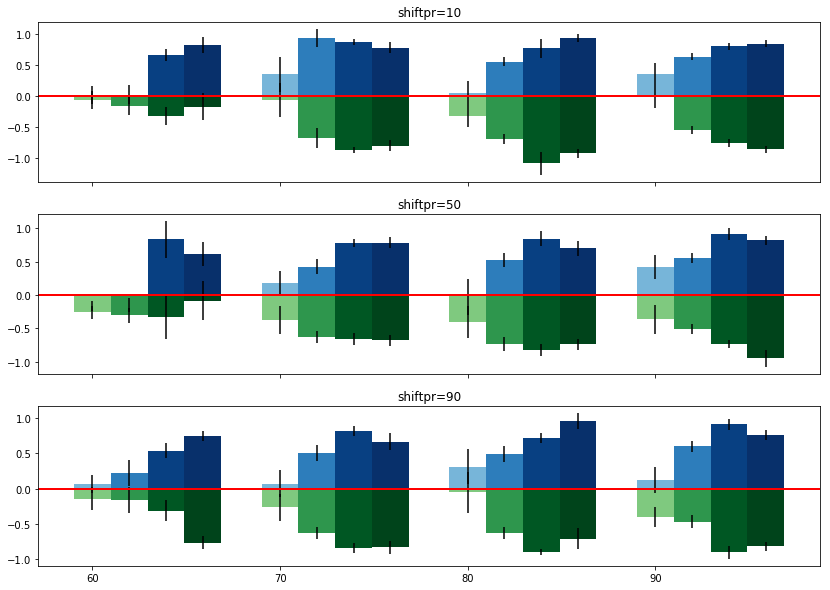

In [ ]:
maxN = 25
sweep = 'csw'

stsizeL = [5,10,20,50]
cswL = [60,70,80,90]
shiftprL=[10,50,90]
fig,axarr = plt.subplots(3,1,figsize=(14,10),sharex=True);axarr = axarr.reshape(-1)
bw = .2

seq1 = 'A1A1A1A1A1A1'
seq2 = 'B1B1B1B1B1B1'

for shift_idx,shiftpr in enumerate(shiftprL):
  ax = axarr[shift_idx]
  ax.set_title('shiftpr=%i'%shiftpr)
  for (st_idx,stsize),(csw_idx,csw) in itertools.product(enumerate(stsizeL),enumerate(cswL)):
    # load sequences
    eval_data = load_data_arr(stsize,csw,shiftpr,'eval',maxN=maxN)
    seq1_states = eval_data[seq1]['states'][:,-7:,:]
    seq2_states = eval_data[seq2]['states'][:,-7:,:]
    # initialize
    Nnets,_,_ = seq1_states.shape
    svm_score1 = np.zeros([Nnets])
    svm_score2 = np.zeros([Nnets])
    for tr_idx in range(3):  
      # train and test indices
      eval_tstepL = [2,3,4] 
      tr_tstep = eval_tstepL.pop(tr_idx)
      # train and test sequences
      trseq1 = np.expand_dims(seq1_states[:,tr_tstep,:],1)
      trseq2 = np.expand_dims(seq2_states[:,tr_tstep,:],1)
      evalseq1 = seq1_states[:,eval_tstepL,:]
      evalseq2 = seq2_states[:,eval_tstepL,:]
      # svm fits
      svm_score1 += fiteval_svm(trseq1,trseq2,evalseq1).mean(1)/3
      svm_score2 += fiteval_svm(trseq1,trseq2,evalseq2).mean(1)/3

    M1 = svm_score1.mean()
    M2 = svm_score2.mean()
    S1 = svm_score1.std()/np.sqrt(Nnets)
    S2 = svm_score2.std()/np.sqrt(Nnets)
    if sweep == 'csw':
      ax.bar(csw_idx*1.02+bw*st_idx,M1,yerr=S1,width=bw,color=plt.get_cmap('Blues')((st_idx+2)*60))
      ax.bar(csw_idx*1.02+bw*st_idx,M2,yerr=S2,width=bw,color=plt.get_cmap('Greens')((st_idx+2)*60))
      ax.set_xticks(np.arange(0,len(cswL),1.02))
      ax.set_xticklabels(cswL)
    if sweep == 'stsize':
      ax.bar(st_idx*1.02+bw*csw_idx,M1,yerr=S1,width=bw,color=plt.get_cmap('Blues')((csw_idx+2)*60))
      ax.bar(st_idx*1.02+bw*csw_idx,M2,yerr=S2,width=bw,color=plt.get_cmap('Greens')((csw_idx+2)*60))
      ax.set_xticks(np.arange(0,len(stsizeL),1.02))
      ax.set_xticklabels(stsizeL)
  ax.axhline(0,lw=2,c='red')
  
  
if sweep == 'csw':
  plt.savefig('figures/csw_tpgen/barSVM-sweep_csw-sweep_stsize-by_csw')
if sweep == 'stsize':
  plt.savefig('figures/csw_tpgen/barSVM-sweep_csw-sweep_stsize-by_stsize')


## RSM

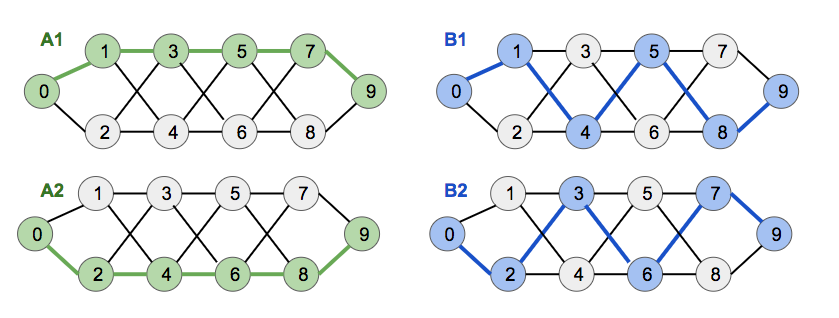

## state-by-state RSM plots

In [4]:
maxN=25

shiftprL=[10,50,90]
stsizeL=[5,10,20,50]
cswL=[60,70,80,90]

for shiftpr in shiftprL:
  fig,axarr = plt.subplots(len(cswL),len(stsizeL),figsize=(10*len(cswL),10*len(stsizeL)))
  for st_idx,stsize in enumerate(stsizeL):
    for csw_idx,csw in enumerate(cswL):
      print(shiftpr,stsize,csw)
      ax = axarr[csw_idx,st_idx]
      eval_data = load_data_arr(stsize,csw,shiftpr,'eval',maxN=maxN)
      ## take last story
      B1_states = eval_data['B1B1B1B1B1B1']['states'][:,-7:,:]
      B2_states = eval_data['B2B2B2B2B2B2']['states'][:,-7:,:]
      A1_states = eval_data['A1A1A1A1A1A1']['states'][:,-7:,:]
      A2_states = eval_data['A2A2A2A2A2A2']['states'][:,-7:,:]
      ## sort by index id
      A_reorder = [0,7+0, 1,1+7, 2,2+7, 3,3+7, 4,4+7, 5,5+7, 6,6+7]
      B_reorder = [0,7+0, 1,1+7, 2,2+7, 3+7,3, 4,4+7, 5+7,5, 6,6+7]
      A_states = np.concatenate([A1_states,A2_states],1)[:,A_reorder,:]
      B_states = np.concatenate([B1_states,B2_states],1)[:,B_reorder,:]
      ## compute group RSM
      RSM = np.zeros([28,28])
      Nnets = len(A_states)
      for net in range(Nnets):
        sub_rsm = np.corrcoef(np.concatenate([A_states[net,:,:],B_states[net,:,:]],axis=0))
        RSM += sub_rsm/Nnets
      im = ax.imshow(RSM)
      ax.set_title('stsize=%i, csw=%i'%(stsize,csw))
      plt.colorbar(im,ax=ax,ticks=[-.5,1])

  plt.savefig('figures/RSM-sorted_input_idx-shiftpr_%i'%(shiftpr))
  plt.close('all')

10 5 60
found N = 22
10 5 70
found N = 22
10 5 80
found N = 22
10 5 90
found N = 22
10 10 60
found N = 23
10 10 70
found N = 23
10 10 80
found N = 23
10 10 90
found N = 23
10 20 60
found N = 23
10 20 70
found N = 23
10 20 80
found N = 23
10 20 90
found N = 23
10 50 60
found N = 23
10 50 70
found N = 23
10 50 80
found N = 23
10 50 90
found N = 23
50 5 60
found N = 22
50 5 70
found N = 22
50 5 80
found N = 22
50 5 90
found N = 22
50 10 60
found N = 23
50 10 70
found N = 23
50 10 80
found N = 23
50 10 90
found N = 23
50 20 60
found N = 23
50 20 70
found N = 23
50 20 80
found N = 23
50 20 90
found N = 23
50 50 60
found N = 23
50 50 70
found N = 23
50 50 80
found N = 23
50 50 90
found N = 23
90 5 60
found N = 22
90 5 70
found N = 23
90 5 80
found N = 22
90 5 90
found N = 22
90 10 60
found N = 23
90 10 70
found N = 23
90 10 80
found N = 23
90 10 90
found N = 23
90 20 60
found N = 23
90 20 70
found N = 23
90 20 80
found N = 22
90 20 90
found N = 23
90 50 60
found N = 23
90 50 70
found N = 23
